In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import folium as fo
import json
from itertools import compress
%matplotlib inline

## LOAD RESOURCES ##

In [2]:
path = 'resources/food-inspections-cleaned.parquet'
df = pd.read_parquet(path)
df.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,None,41.965719,-87.708538,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38


In [3]:
nb_NaN_violations = len(df) - df['Violations'].count()
print("We have {} out of {} inspections with no violations recorded. It makes {}%.".format(nb_NaN_violations, len(df), "%.2f" % (nb_NaN_violations/len(df)*100)))

We have 51070 out of 191827 inspections with no violations recorded. It makes 26.62%.


## EXPLODE VIOLATIONS ##

In [4]:
df_split = df.copy()
df_split['Violations'] = df_split['Violations'].map(lambda x: str(x).split('|'))
#df_split.head(3)

In [5]:
violations = df_split.explode('Violations').rename(columns={'Violations' : 'Violation'})
violations = violations[violations['Violation'] != 'None']
nb_violations = len(violations)
#violations.head()

## Categorize Violations ##

In [10]:
others = ['* CERTIFIED FOOD MANAGER ON SITE WHEN POTENTIALLY HAZARDOUS FOODS ARE  PREPARED AND SERVED',
'COMPLIANCE WITH VARIANCE/SPECIALIZED PROCESS/HACCP',
    'VARIANCE OBTAINED FOR SPECIALIZED PROCESSING METHODS',
    'CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE',
     'REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAGS, PARASITE DESTRUCTION',]

corrected = ['PREVIOUS CORE VIOLATION CORRECTED',
 'PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-090',
 'PREVIOUS PRIORITY FOUNDATION VIOLATION CORRECTED',
 'PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42-090',
 'REMOVAL OF SUSPENSION SIGN',
]    

personnel = [# employee
'FOOD HANDLER REQUIREMENTS MET',
'ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING',
'MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING',
    'PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES',

     'ONLY AUTHORIZED PERSONNEL IN THE FOOD-PREP AREA', #??????
    'PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS',
]    
    


# other species 
guests=['INSECTS, RODENTS, & ANIMALS NOT PRESENT',
'NO EVIDENCE OF RODENT OR INSECT INFESTATION, NO BIRDS, TURTLES OR OTHER ANIMALS',
    'NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS',
]
# consumer info
consumer = ['CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCOOKED FOOD',
'* INSPECTION REPORT SUMMARY DISPLAYED AND VISIBLE TO ALL CUSTOMERS',
     'SUMMARY REPORT DISPLAYED AND VISIBLE TO THE PUBLIC',
     'TIME AS A PUBLIC HEALTH CONTROL; PROCEDURES & RECORDS',
]



# human hygyene
hygyene = [    'PERSONAL CLEANLINESS',
     'PERSONNEL WITH INFECTIONS RESTRICTED: NO OPEN SORES, WOUNDS, ETC',
'ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE',
'HAND WASHING FACILITIES: WITH SOAP AND SANITARY HAND DRYING DEVICES, CONVENIENT AND ACCESSIBLE TO FOOD PREP AREA',
'HANDS CLEAN & PROPERLY WASHED',
'HANDS WASHED AND CLEANED, GOOD HYGIENIC PRACTICES; NO BARE HAND CONTACT WITH READY-TO-EAT FOODS.',
'NO DISCHARGE FROM EYES, NOSE, AND MOUTH',#????
'NO BARE HAND CONTACT WITH RTE FOOD OR A PRE-APPROVED ALTERNATIVE PROCEDURE PROPERLY ALLOWED', ###?

 'WASH AND RINSE WATER: CLEAN AND PROPER TEMPERATURE', #????
]







    #source
source = ['FOOD ADDITIVES: APPROVED AND PROPERLY USED',
'FOOD OBTAINED FROM APPROVED SOURCE',

'FOOD IN GOOD CONDITION, SAFE, & UNADULTERATED',
 'SOURCE OF CROSS CONTAMINATION CONTROLLED I.E',
     'WATER & ICE FROM APPROVED SOURCE',
        'ALLERGEN TRAINING AS REQUIRED', #???
]

    
# food control
control = ['PASTEURIZED EGGS USED WHERE REQUIRED',
'PASTEURIZED FOODS USED; PROHIBITED FOODS NOT OFFERED',

         'PROPER DATE MARKING AND DISPOSITION',
 'PROPER DISPOSITION OF RETURNED, PREVIOUSLY SERVED, RECONDITIONED & UNSAFE FOOD',
 'TOXIC ITEMS PROPERLY STORED, LABELED AND USED',
 'TOXIC SUBSTANCES PROPERLY IDENTIFIED, STORED, & USED',
 'UNWRAPPED AND POTENTIALLY HAZARDOUS FOOD NOT RE-SERVED',
     'WASHING FRUITS & VEGETABLES',
]

# food storage - physical
storage = ['FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED',
'FOOD PROPERLY LABELED; ORIGINAL CONTAINER',
'FOOD SEPARATED AND PROTECTED',

'CONTAMINATION PREVENTED DURING FOOD PREPARATION, STORAGE & DISPLAY',
'FOOD PROTECTED DURING STORAGE, PREPARATION, DISPLAY, SERVICE AND TRANSPORTATION',
'INSIDE CONTAINERS OR RECEPTACLES: ADEQUATE NUMBER, PROPERLY COVERED AND INSECT/RODENT PROOF', #??????
]

# contacting utensils  
utensils = ['CLEAN MULTI-USE UTENSILS AND SINGLE SERVICE ARTICLES PROPERLY STORED: NO REUSE OF SINGLE SERVICE ARTICLES',
'DISH MACHINES: PROVIDED WITH ACCURATE THERMOMETERS, CHEMICAL TEST KITS AND SUITABLE GAUGE COCK',
'DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED',
'DISHES AND UTENSILS FLUSHED, SCRAPED, SOAKED',
'FOOD (ICE) DISPENSING UTENSILS, WASH CLOTHS PROPERLY STORED',
'GLOVES USED PROPERLY',
'IN-USE UTENSILS: PROPERLY STORED',
'LINEN: CLEAN AND SOILED PROPERLY STORED',
    'SANITIZING RINSE FOR EQUIPMENT AND UTENSILS:  CLEAN, PROPER TEMPERATURE, CONCENTRATION, EXPOSURE TIME',
    'SINGLE-USE/SINGLE-SERVICE ARTICLES: PROPERLY STORED & USED',
     'UTENSILS, EQUIPMENT & LINENS: PROPERLY STORED, DRIED, & HANDLED',
     'WIPING CLOTHS: PROPERLY USED & STORED',
]


#food temp / cooking
food_temp = ['FOOD RECEIVED AT PROPER TEMPERATURE',
 'REFRIGERATION AND METAL STEM THERMOMETERS PROVIDED AND CONSPICUOUS',
    
'PLANT FOOD PROPERLY COOKED FOR HOT HOLDING',
    
 'POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE REQUIREMENT DURING STORAGE, PREPARATION DISPLAY AND SERVICE',
 'POTENTIALLY HAZARDOUS FOOD PROPERLY THAWED',
    
'PROPER COLD HOLDING TEMPERATURES',
 'PROPER COOKING TIME & TEMPERATURES',
 'PROPER COOLING METHODS USED; ADEQUATE EQUIPMENT FOR TEMPERATURE CONTROL',
 'PROPER COOLING TIME AND TEMPERATURE',
    
 'PROPER HOT HOLDING TEMPERATURES',
 'PROPER REHEATING PROCEDURES FOR HOT HOLDING',
 #thawing
'APPROVED THAWING METHODS USED',

]    
    

#food contact  
food_contact = ['FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PROPERLY DESIGNED, CONSTRUCTED & USED',
'FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
'FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
'APPROPRIATE METHOD OF HANDLING OF FOOD (ICE) HAIR RESTRAINTS AND CLEAN APPAREL WORN',
'FOOD-CONTACT SURFACES: CLEANED & SANITIZED',
]
# general
general = ['NON-FOOD/FOOD CONTACT SURFACES CLEAN',
    'PROPER EATING, TASTING, DRINKING, OR TOBACCO USE',
    'PROPER USE OF RESTRICTION AND EXCLUSION',
     'SOURCE SOUND CONDITION, NO SPOILAGE, FOODS PROPERLY LABELED, SHELLFISH TAGS IN PLACE',
               'NO SMOKING REGULATIONS',
           'ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIGNED, AND MAINTAINED',
'ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, PROPERLY DESIGNED AND INSTALLED',

]

    
#facility
facility = ['LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED',
'FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED',

 'OUTSIDE GARBAGE WASTE GREASE AND STORAGE AREA; CLEAN, RODENT PROOF, ALL CONTAINERS COVERED',
'GARBAGE & REFUSE PROPERLY DISPOSED; FACILITIES MAINTAINED',
'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN',
 'PLUMBING INSTALLED; PROPER BACKFLOW DEVICES',
     'PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING  EQUIPMENT PROPERLY STORED',
     'SEWAGE AND WASTE WATER DISPOSAL, NO BACK SIPHONAGE, CROSS  CONNECTION AND/OR BACK FLOW',
     'SEWAGE & WASTE WATER PROPERLY DISPOSED',
    'TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED',
 'TOILET ROOM DOORS SELF CLOSING: DRESSING ROOMS WITH LOCKERS PROVIDED: COMPLETE SEPARATION FROM LIVING/SLEEPING QUARTERS',
 'TOILET ROOMS ENCLOSED CLEAN, PROVIDED WITH HAND CLEANSER, SANITARY HAND DRYING DEVICES AND PROPER WASTE RECEPTACLES',
 'THERMOMETERS PROVIDED & ACCURATE',
'WAREWASHING FACILITIES: INSTALLED, MAINTAINED & USED; TEST STRIPS',
'WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS',
 'WATER SOURCE: SAFE, HOT & COLD UNDER CITY PRESSURE',
            # facility temp
'FACILITIES TO MAINTAIN PROPER TEMPERATURE',
            'HOT & COLD WATER AVAILABLE; ADEQUATE PRESSURE',
    
# facility air 
'COMPLIANCE WITH CLEAN INDOOR AIR ORDINANCE',
'ADEQUATE VENTILATION & LIGHTING; DESIGNATED AREAS USED',
 'VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED',


]




In [11]:
def violation_redefine(v):
    if v in others:
        return 'others'
    elif v in corrected:
        return 'corrected'
    elif v in personnel:
        return 'personnel'
    elif v in guests:
        return 'guests'
    elif v in consumer:
        return 'consumer'
    elif v in hygyene:
        return 'hygene'
    elif v in source:
        return 'source'
    elif v in control:
        return 'control'
    elif v in storage:
        return 'storage'
    elif v in utensils:
        return 'utensils'
    elif v in food_temp:
        return 'food_temp'
    elif v in food_contact:
        return 'food_contact'
    elif v in general:
        return 'general'
    elif v in facility:
        return 'facility'
    else:
        return 'not defined'

    #others
#corrected
#personnel
#guests
# consumer
#hygyene
#source
#control
#storage 
#utensils  
#food_temp
#food_contact  
# general
#facility

In [12]:
violations['violation_simple'] = violations['Violation'].apply(lambda x:x.split('Comments')[0].strip(' - ').split('. ')[1])
violations['violation_simple'] = violations.violation_simple.apply(violation_redefine)
#violations[['Inspection Date','violation_simple']]

In [13]:
viols_count = violations['Violation'].apply(lambda x:x.split('Comments')[0].strip(' - ').split('. ')[1]).value_counts()
#viols_count[viols_count > viols_count.mean()]

### Check Rodents related issues ###

In [14]:
result = violations[['Community','Inspection Date','violation_simple']].copy()

In [15]:
result['Inspection Date'] = result['Inspection Date'].apply(lambda x: x.year)
result.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
rodents = result[result.violation_simple.apply(lambda x:x == 'guests')]

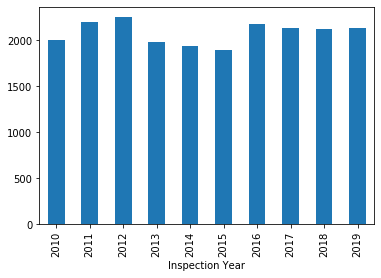

In [16]:
rodents.groupby('Inspection Year').size().plot.bar()

 total occurence of insenct/rodent related violation doesn't change much

## Rodents occurence per community ##

In [20]:
for i in range(10):
    m_violations = fo.Map(location=[41.8281136,-87.6297982], zoom_start=10, zoom_control=False)
    df = pd.DataFrame(rodents[rodents['Inspection Year'] == (i+2010)].groupby('Community').size())    

    nds = pd.DataFrame()
    nds['Community'] = df.index.astype('str')
    nds['Nb Violations'] = df[0].values
    fe1 = fo.Choropleth(
        geo_data='resources/geojsons/chicago-community.geojson',
        name='Violations by communities',
        data=nds,
        columns=['Community', 'Nb Violations'],
        key_on='properties.community',
        fill_color='Reds',
        fill_opacity=0.8,
        line_opacity=0.2,
        legend_name=' Mean of number of violations by community (in %)',

    )
    fe1.add_to(m_violations)
    m_violations.save(outfile='results/violation_studies/community-unwantedguests-{0}.html'.format(i+2010))
    
# how to fix threshold throughout the html?

The rodents/insect issues are likely to happen in northern part of Chicago. This is quite counter-intuitive, since it's more sensible to guess that rodents will likely to appear in poor regions. In the map, the region that has most 'violation' on rodents is the richest part of Chicago. 

## In order to compare the absolute value, try using bar chart ##

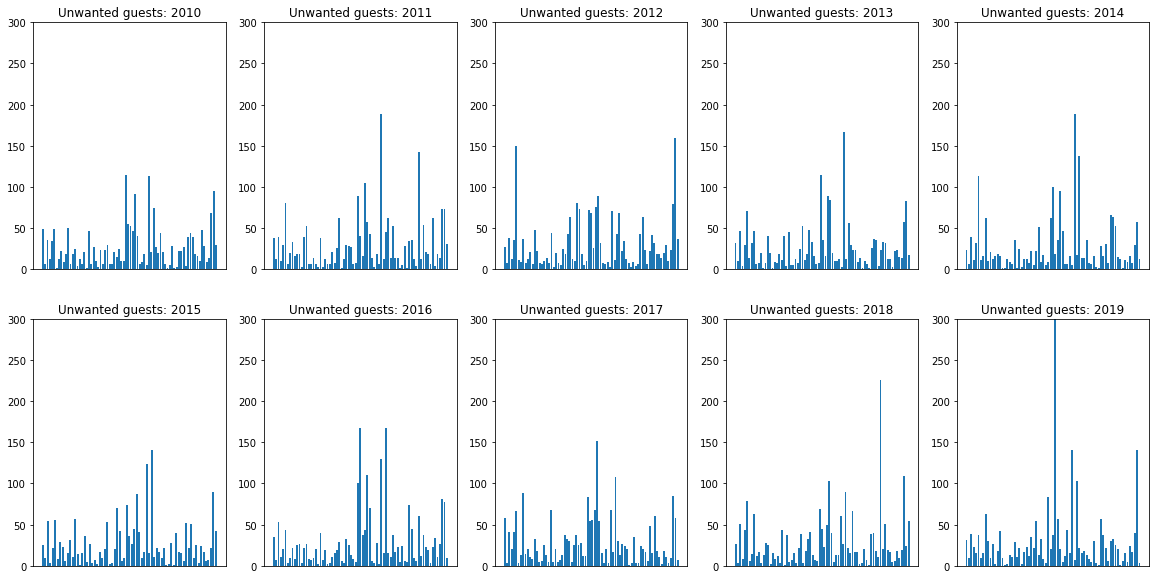

In [18]:
fig, axs = plt.subplots(2,5, figsize=(20, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(10):
    df = pd.DataFrame(rodents[rodents['Inspection Year'] == (i+2010)].groupby('Community').size())    
    
    axs[i].bar(df.index, df[0])
    axs[i].set_ylim(0,300)
    axs[i].set_title('Unwanted guests: {0}'.format(i + 2010))
    axs[i].set_xticks([])

    

In [9]:
# geo of no violation